In [1]:
# Install gensim for word embeddings
!pip install gensim

In [2]:
# Install necessary libraries
!pip install gensim keras-tuner imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import nltk
import string
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import gensim
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import keras_tuner as kt
from imblearn.over_sampling import SMOTE

In [4]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load the GloVe vectors
glove_file = '/content/drive/My Drive/AFIT/Thesis/Sentiment Label Test/glove.6B.100d.txt'
glove_model = gensim.models.KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

In [7]:
# Define File Paths to Google Drive
file_paths = {
    'Twitter': '/content/drive/My Drive/AFIT/Thesis/Sentiment Label Test/Twitter_Data.csv',
    'Reddit': '/content/drive/My Drive/AFIT/Thesis/Sentiment Label Test/Reddit_Data.csv',
    'News': '/content/drive/My Drive/AFIT/Thesis/Sentiment Label Test/Fin_Cleaned.csv',
    'Sports': '/content/drive/My Drive/AFIT/Thesis/Sentiment Label Test/Sports_short.csv',
    'Education': '/content/drive/My Drive/AFIT/Thesis/Sentiment Label Test/Education_short.csv',
    'Finance': '/content/drive/My Drive/AFIT/Thesis/Sentiment Label Test/Finance_short.csv',
    'Politics': '/content/drive/My Drive/AFIT/Thesis/Sentiment Label Test/Politics_short.csv'
}

In [8]:
# Load Data Sets
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

In [9]:
# Text Preprocessing Function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    if isinstance(text, float):  # handle NaN values
        return ""
    text = text.lower()  # Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ''.join([i for i in text if not i.isdigit()])  # Remove numbers
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Remove stop words and lemmatize
    return ' '.join(words)

# Define text columns for each dataset
text_columns = {
    'Twitter': 'clean_text',
    'Reddit': 'clean_comment',
    'News': 'Full_text',
    'Sports': 'Text',
    'Education': 'Text',
    'Finance': 'Text',
    'Politics': 'Text'
}

# Preprocess the text columns in each dataset
for name, df in datasets.items():
    df['text'] = df[text_columns[name]].apply(preprocess)

# Function to handle case-insensitive label conversion
def convert_sentiment_label(label):
    try:
        label = float(label)  # Convert label to float
    except ValueError:
        label = str(label).lower()  # Convert label to lowercase string if not a float

    if label == 'positive' or label == 1:
        return 1
    elif label == 'neutral' or label == 0:
        return 0
    elif label == 'negative' or label == -1:
        return -1
    return np.nan  # Handle unexpected values

# Ensure 'label' column exists in all datasets and convert labels
label_columns = {
    'Twitter': 'category',
    'Reddit': 'category',
    'News': 'Final Status',
    'Sports': 'Label',
    'Education': 'Label',
    'Finance': 'Label',
    'Politics': 'Label'
}

for name, df in datasets.items():
    if 'label' not in df.columns:
        df['label'] = df[label_columns[name]].apply(convert_sentiment_label)

# Remove rows with NaN labels
for df in datasets.values():
    df.dropna(subset=['label'], inplace=True)

In [10]:
# Define maximum number of words and sequence length
max_words = 20000
max_len = 100
embedding_dim = 100  # Dimension of the GloVe embeddings

# Tokenization and Padding
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts([text for df in datasets.values() for text in df['text']])

# Get the word index from the tokenizer
word_index = tokenizer.word_index

# Convert text to sequences and pad them
train_test_data = []
for name, df in datasets.items():
    sequences = tokenizer.texts_to_sequences(df['text'])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    labels = df['label'].values

    # Convert labels to categorical if ternary classification
    if name in ['Twitter', 'Reddit']:
        labels = to_categorical(labels, num_classes=3)

    X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
    train_test_data.append((X_train, X_test, y_train, y_test))

# Verify the tokenization and padding
for (X_train_pad, X_test_pad, y_train, y_test), name in zip(train_test_data, datasets.keys()):
    print(f"Dataset: {name}")
    print(f"X_train_pad shape: {X_train_pad.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test_pad shape: {X_test_pad.shape}")
    print(f"y_test shape: {y_test.shape}")
    print("\n")

Dataset: Twitter
X_train_pad shape: (130378, 100)
y_train shape: (130378, 3)
X_test_pad shape: (32595, 100)
y_test shape: (32595, 3)


Dataset: Reddit
X_train_pad shape: (29799, 100)
y_train shape: (29799, 3)
X_test_pad shape: (7450, 100)
y_test shape: (7450, 3)


Dataset: News
X_train_pad shape: (319, 100)
y_train shape: (319,)
X_test_pad shape: (80, 100)
y_test shape: (80,)


Dataset: Sports
X_train_pad shape: (44, 100)
y_train shape: (44,)
X_test_pad shape: (12, 100)
y_test shape: (12,)


Dataset: Education
X_train_pad shape: (41, 100)
y_train shape: (41,)
X_test_pad shape: (11, 100)
y_test shape: (11,)


Dataset: Finance
X_train_pad shape: (38, 100)
y_train shape: (38,)
X_test_pad shape: (10, 100)
y_test shape: (10,)


Dataset: Politics
X_train_pad shape: (42, 100)
y_train shape: (42,)
X_test_pad shape: (11, 100)
y_test shape: (11,)




In [11]:
# Create embedding matrix using GloVe
def create_embedding_matrix(word_index, embedding_model, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in embedding_model.key_to_index:
            embedding_matrix[i] = embedding_model[word]
    return embedding_matrix

embedding_matrix = create_embedding_matrix(word_index, glove_model, embedding_dim)

In [12]:
# Define CNN Model
def build_cnn_model(hp, num_classes, word_index, embedding_matrix):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu'
    ))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)))

    # Output layer
    if num_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        model.add(Dense(num_classes, activation='softmax'))
        loss = 'categorical_crossentropy'

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss=loss,
        metrics=['accuracy']
    )
    return model

# Define Bi-LSTM Model
def build_bilstm_model(hp, num_classes, word_index, embedding_matrix):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=True, dropout=hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)
    )))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)))

    # Output layer
    if num_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        model.add(Dense(num_classes, activation='softmax'))
        loss = 'categorical_crossentropy'

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss=loss,
        metrics=['accuracy']
    )
    return model

# Function to evaluate the models
def evaluate_model(df, prediction_column):
    accuracy = accuracy_score(df['label'], df[prediction_column])
    f1 = f1_score(df['label'], df[prediction_column], average='weighted')
    precision = precision_score(df['label'], df[prediction_column], average='weighted')
    recall = recall_score(df['label'], df[prediction_column], average='weighted')
    return accuracy, f1, precision, recall

# Initialize dictionaries to store results for each model and dataset
results_cnn = {}
results_bilstm = {}

# Function to Train and Evaluate the Tuner Models (CNN and Bi-LSTM)
def run_tuner_model(tuner, X_train_pad, X_test_pad, y_train, y_test, name):
    tuner.search(X_train_pad, y_train, epochs=10, batch_size=16, validation_split=0.2)

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"\nBest hyperparameters for {name}:")
    print(best_hps.values)

    # Build the model with the optimal hyperparameters and train it
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train_pad, y_train, epochs=10, batch_size=16, validation_split=0.2)

    # Evaluate on test data
    test_metrics = model.evaluate(X_test_pad, y_test)
    print(f"{name} - Test Loss: {test_metrics[0]}, Test Accuracy: {test_metrics[1]}")

    # Predict and evaluate with classification metrics
    predictions = model.predict(X_test_pad)

    if len(predictions.shape) == 1 or predictions.shape[1] == 1:  # Binary classification
        predictions = [1 if p >= 0.5 else 0 for p in predictions]
    else:  # Ternary classification
        predictions = np.argmax(predictions, axis=1)
        y_test = np.argmax(y_test, axis=1)

    evaluation_metrics = evaluate_model(pd.DataFrame({'label': y_test, 'prediction': predictions}), 'prediction')
    print(f"{name} - Accuracy: {evaluation_metrics[0]}, F1: {evaluation_metrics[1]}, Precision: {evaluation_metrics[2]}, Recall: {evaluation_metrics[3]}")

    # Store the results in the dictionary
    if 'CNN' in name:
        results_cnn[name] = {'loss': test_metrics[0], 'accuracy': test_metrics[1], 'f1': evaluation_metrics[1], 'precision': evaluation_metrics[2], 'recall': evaluation_metrics[3]}
    elif 'Bi-LSTM' in name:
        results_bilstm[name] = {'loss': test_metrics[0], 'accuracy': test_metrics[1], 'f1': evaluation_metrics[1], 'precision': evaluation_metrics[2], 'recall': evaluation_metrics[3]}

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Trial 30 Complete [00h 00m 08s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.4444444477558136
Total elapsed time: 00h 03m 34s

Best hyperparameters for CNN - Politics:
{'filters': 32, 'kernel_size': 7, 'dense_units': 20, 'dropout_rate': 0.2, 'learning_rate': 0.0007296560092028349, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - accuracy: 0.3464 - loss: 0.7854 - val_accuracy: 0.0000e+00 - val_loss: 0.4377
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 0.4657 - val_accuracy: 0.0000e+00 - val_loss: 0.2539
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0386 - loss: 0.1643 - val_accuracy: 0.0000e+00 - val_loss: 0.1408
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0283 - val_accuracy: 0.0000e+00 - val_loss: 0.0355
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: -0.1540 - val_accuracy: 0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


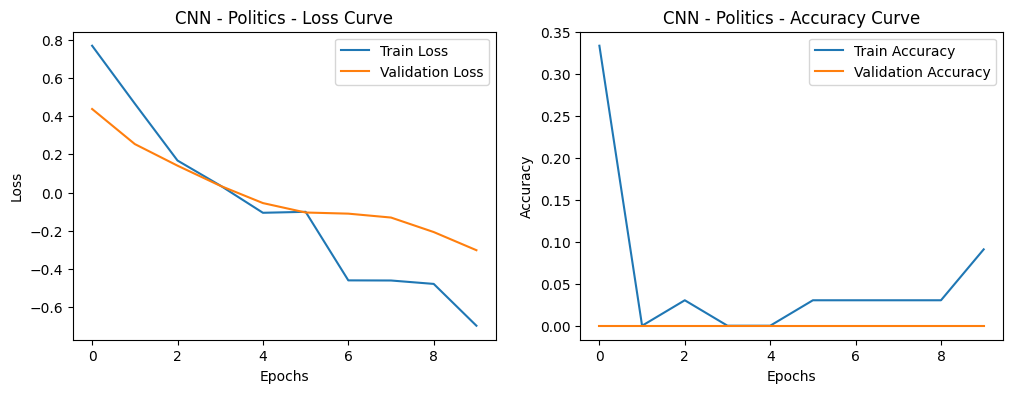

In [13]:
# Run Tuner for CNN for each dataset
for (X_train_pad, X_test_pad, y_train, y_test), name in zip(train_test_data, datasets.keys()):
    num_classes = 3 if name in ['Twitter', 'Reddit'] else 2
    print(f"\n--- Running CNN Tuner for {name} with {num_classes} classes ---")
    cnn_tuner = kt.Hyperband(
        lambda hp: build_cnn_model(hp, num_classes, word_index, embedding_matrix),
        objective='val_accuracy',
        max_epochs=10,
        factor=3,
        directory='cnn_tuner',
        project_name=name
    )
    run_tuner_model(cnn_tuner, X_train_pad, X_test_pad, y_train, y_test, f"CNN - {name}")

Trial 30 Complete [00h 00m 13s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.4444444477558136
Total elapsed time: 00h 06m 00s

Best hyperparameters for Bi-LSTM - Politics:
{'lstm_units': 128, 'dropout_rate': 0.6000000000000001, 'dense_units': 10, 'learning_rate': 0.0067627454521680085, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.1544 - loss: 0.6609 - val_accuracy: 0.0000e+00 - val_loss: 0.0345
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0000e+00 - loss: 0.5010 - val_accuracy: 0.0000e+00 - val_loss: -0.2990
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0000e+00 - loss: -0.5268 - val_accuracy: 0.0000e+00 - val_loss: -0.4329
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0000e+00 - loss: -0.0306 - val_accuracy: 0.0000e+00 - val_loss: -0.4746
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: -1.6903 - val_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


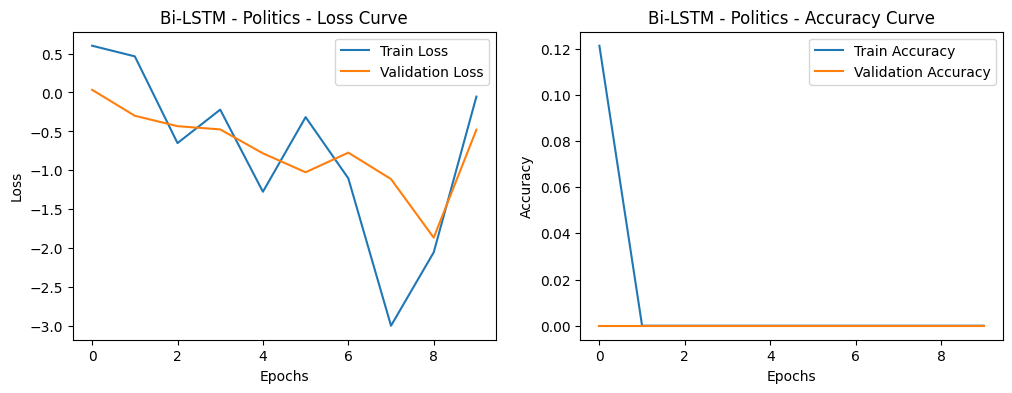

In [14]:
# Run Tuner for Bi-LSTM for each dataset
for (X_train_pad, X_test_pad, y_train, y_test), name in zip(train_test_data, datasets.keys()):
    num_classes = 3 if name in ['Twitter', 'Reddit'] else 2
    print(f"\n--- Running Bi-LSTM Tuner for {name} with {num_classes} classes ---")
    bilstm_tuner = kt.Hyperband(
        lambda hp: build_bilstm_model(hp, num_classes, word_index, embedding_matrix),
        objective='val_accuracy',
        max_epochs=10,
        factor=3,
        directory='bilstm_tuner',
        project_name=name
    )
    run_tuner_model(bilstm_tuner, X_train_pad, X_test_pad, y_train, y_test, f"Bi-LSTM - {name}")


In [15]:
# After all runs, print out the results
print("\n--- CNN Results ---")
for name, metrics in results_cnn.items():
    print(f"{name}: Loss={metrics['loss']}, Accuracy={metrics['accuracy']}, F1={metrics['f1']}, Precision={metrics['precision']}, Recall={metrics['recall']}")

p.rint("\n--- Bi-LSTM Results ---")
f or name, metrics in results_bilstm.items():
    print(f"{name}: Loss={metrics['loss']}, Accuracy={metrics['accuracy']}, F1={metrics['f1']}, Precision={metrics['precision']}, Recall={metrics['recall']}")


--- CNN Results ---
CNN - Twitter: Loss=0.6345801949501038, Accuracy=0.7787083983421326, F1=0.7840576427418345, Precision=0.8042346838851024, Recall=0.7787083908574934
CNN - Reddit: Loss=0.7786521315574646, Accuracy=0.7497986555099487, F1=0.7371285127203827, Precision=0.7480940096126428, Recall=0.7497986577181208
CNN - News: Loss=-0.128960520029068, Accuracy=0.0, F1=0.0, Precision=0.0, Recall=0.0
CNN - Sports: Loss=-0.828258216381073, Accuracy=0.0, F1=0.0, Precision=0.0, Recall=0.0
CNN - Education: Loss=0.7201610803604126, Accuracy=0.0, F1=0.0, Precision=0.0, Recall=0.0
CNN - Finance: Loss=-2.8233697414398193, Accuracy=0.699999988079071, F1=0.7, Precision=0.7, Recall=0.7
CNN - Politics: Loss=-0.09413787722587585, Accuracy=0.0, F1=0.0, Precision=0.0, Recall=0.0

--- Bi-LSTM Results ---
Bi-LSTM - Twitter: Loss=0.3928986191749573, Accuracy=0.8683540225028992, F1=0.8683567238848816, Precision=0.8696109519967936, Recall=0.8679245283018868
Bi-LSTM - Reddit: Loss=0.5210325121879578, Accuracy

Stop block

In [ ]:
# Function to ensure that all labels are in the same dimensional format
def adjust_label_dimension(y, num_classes):
    if len(y.shape) == 1 and num_classes > 2:  # Convert to one-hot if not already
        return to_categorical(y, num_classes=num_classes)
    elif len(y.shape) == 2 and y.shape[1] == 1:  # Convert from one-hot to flat if necessary
        return np.argmax(y, axis=1)
    return y

# Adjust labels for binary datasets to be 2D and one-hot encoded
adjusted_train_test_data = []
for (X_train_pad, X_test_pad, y_train, y_test), name in zip(train_test_data, datasets.keys()):
    num_classes = 3 if name in ['Twitter', 'Reddit'] else 2
    y_train = adjust_label_dimension(y_train, num_classes)
    y_test = adjust_label_dimension(y_test, num_classes)
    adjusted_train_test_data.append((X_train_pad, X_test_pad, y_train, y_test))

# Now use the adjusted data for concatenation
combined_X_train_pad = np.vstack([X_train_pad for X_train_pad, _, _, _ in adjusted_train_test_data])
combined_X_test_pad = np.vstack([X_test_pad for _, X_test_pad, _, _ in adjusted_train_test_data])
combined_y_train = np.vstack([y_train for _, _, y_train, _ in adjusted_train_test_data])
combined_y_test = np.vstack([y_test for _, _, _, y_test in adjusted_train_test_data])

# CNN Combined
print("\n--- Running CNN Tuner for Combined Dataset ---")
cnn_tuner_combined = kt.Hyperband(
    lambda hp: build_cnn_model(hp, 3, word_index, embedding_matrix),  # Adjust for the appropriate number of classes
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='cnn_combined_tuner',
    project_name='Combined Dataset'
)
run_tuner_model(cnn_tuner_combined, combined_X_train_pad, combined_X_test_pad, combined_y_train, combined_y_test, 'CNN - Combined Dataset')

# Bi-LSTM Combined
print("\n--- Running Bi-LSTM Tuner for Combined Dataset ---")
bilstm_tuner_combined = kt.Hyperband(
    lambda hp: build_bilstm_model(hp, 3, word_index, embedding_matrix),  # Adjust for the appropriate number of classes
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='bilstm_combined_tuner',
    project_name='Combined Dataset'
)
run_tuner_model(bilstm_tuner_combined, combined_X_train_pad, combined_X_test_pad, combined_y_train, combined_y_test, 'Bi-LSTM - Combined Dataset')

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 2 has 1 dimension(s)

In [ ]:
# Bi-LSTM Model Definition
def build_bilstm_model(hp, num_classes):
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=True, dropout=hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)
    )))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)))
    model.add(Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Function to Train and Evaluate the Tuner Models (CNN and Bi-LSTM)
def run_tuner_model(tuner, X_train_pad, X_test_pad, y_train, y_test, name, num_classes):
    tuner.search(X_train_pad, y_train, epochs=10, batch_size=16, validation_split=0.2)

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"\nBest hyperparameters for {name}:")
    print(best_hps.values)

    # Build the model with the optimal hyperparameters and train it
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train_pad, y_train, epochs=10, batch_size=16, validation_split=0.2)

    # Evaluate on test data
    test_metrics = model.evaluate(X_test_pad, y_test)
    print(f"{name} - Test Loss: {test_metrics[0]}, Test Accuracy: {test_metrics[1]}")

    # Predict and evaluate with classification metrics
    predictions = model.predict(X_test_pad)
    if num_classes > 2:
        predictions = np.argmax(predictions, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)
    else:
        predictions = [1 if p >= 0.5 else 0 for p in predictions]
        y_test_labels = y_test

    evaluation_metrics = evaluate_model(pd.DataFrame({'label': y_test_labels, 'prediction': predictions}), 'prediction')
    print(f"{name} - Accuracy: {evaluation_metrics[0]}, F1: {evaluation_metrics[1]}, Precision: {evaluation_metrics[2]}, Recall: {evaluation_metrics[3]}")

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [ ]:
# CNN and Bi-LSTM Model Tuner Configuration
def run_all_models(train_test_data, dataset_names, num_classes):
    for (X_train_pad, X_test_pad, y_train, y_test), name in zip(train_test_data, dataset_names):
        print(f"\n--- Running CNN Tuner for {name} ---")
        cnn_tuner = kt.Hyperband(
            lambda hp: build_cnn_model(hp, num_classes),
            objective='val_accuracy',
            max_epochs=10,
            factor=3,
            directory='cnn_tuner',
            project_name=name
        )
        run_tuner_model(cnn_tuner, X_train_pad, X_test_pad, y_train, y_test, f"CNN - {name}", num_classes)

        print(f"\n--- Running Bi-LSTM Tuner for {name} ---")
        bilstm_tuner = kt.Hyperband(
            lambda hp: build_bilstm_model(hp, num_classes),
            objective='val_accuracy',
            max_epochs=10,
            factor=3,
            directory='bilstm_tuner',
            project_name=name
        )
        run_tuner_model(bilstm_tuner, X_train_pad, X_test_pad, y_train, y_test, f"Bi-LSTM - {name}", num_classes)

In [ ]:
# Adjust the number of classes for each dataset (2 for binary, 3 for ternary)
for (X_train_pad, X_test_pad, y_train, y_test), name in zip(train_test_data, dataset_names):
    if name in ['Twitter', 'Reddit']:
        num_classes = 3
    else:
        num_classes = 2

    run_all_models([(X_train_pad, X_test_pad, y_train, y_test)], [name], num_classes)

NameError: name 'train_test_data' is not defined

In [ ]:
# Separate features and labels
X = combined_df['text'].values
y = combined_df['label'].values

# Vectorize text data using the tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len)

NameError: name 'combined_df' is not defined

In [ ]:
# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X_pad, y)

# Convert to categorical for ternary classification
y_resampled_cat = to_categorical(y_resampled, num_classes=3)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_cat, test_size=0.2, random_state=42)

NameError: name 'smote' is not defined

In [ ]:
# Check if preprocessing is correctly applied
for df, name in zip(datasets, dataset_names):
    print(f"Dataset: {name}")
    print("Sample preprocessed text:")
    print(df['text'].head(3))  # Display the first 3 preprocessed text entries
    print("Labels distribution:")
    print(df['label'].value_counts())  # Check distribution of sentiment labels
    print("\n")

Dataset: Twitter
Sample preprocessed text:
0    modi promised “minimum government maximum gove...
1               talk nonsense continue drama vote modi
2    say vote modi welcome bjp told rahul main camp...
Name: text, dtype: object
Labels distribution:
label
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64


Dataset: Reddit
Sample preprocessed text:
0    family mormon never tried explain still stare ...
1    buddhism much lot compatible christianity espe...
2    seriously say thing first get complex explain ...
Name: text, dtype: object
Labels distribution:
label
 1    15830
 0    13142
-1     8277
Name: count, dtype: int64


Dataset: News
Sample preprocessed text:
0    reuterspayments company bank loggerhead sharin...
1    agenciesthe bank presently million active user...
2    ptikarnataka chief minister basavaraj bommaika...
Name: text, dtype: object
Labels distribution:
label
 1.0    215
-1.0    184
Name: count, dtype: int64


Dataset: Sports
Sample preprocessed

In [ ]:
# Define maximum number of words and sequence length
max_words = 20000
max_len = 100

# Tokenization and Padding
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts([text for df in datasets for text in df['text']])

# Convert text to sequences and pad them
train_test_data = []
for df in datasets:
    sequences = tokenizer.texts_to_sequences(df['text'])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    labels = df['label'].values
    X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
    train_test_data.append((X_train, X_test, y_train, y_test))

# Verify the tokenization and padding
for (X_train_pad, X_test_pad, y_train, y_test), name in zip(train_test_data, dataset_names):
    print(f"Dataset: {name}")
    print(f"X_train_pad shape: {X_train_pad.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test_pad shape: {X_test_pad.shape}")
    print(f"y_test shape: {y_test.shape}")
    print("\n")

Dataset: Twitter
X_train_pad shape: (130378, 100)
y_train shape: (130378,)
X_test_pad shape: (32595, 100)
y_test shape: (32595,)


Dataset: Reddit
X_train_pad shape: (29799, 100)
y_train shape: (29799,)
X_test_pad shape: (7450, 100)
y_test shape: (7450,)


Dataset: News
X_train_pad shape: (319, 100)
y_train shape: (319,)
X_test_pad shape: (80, 100)
y_test shape: (80,)


Dataset: Sports
X_train_pad shape: (44, 100)
y_train shape: (44,)
X_test_pad shape: (12, 100)
y_test shape: (12,)


Dataset: Education
X_train_pad shape: (41, 100)
y_train shape: (41,)
X_test_pad shape: (11, 100)
y_test shape: (11,)


Dataset: Finance
X_train_pad shape: (38, 100)
y_train shape: (38,)
X_test_pad shape: (10, 100)
y_test shape: (10,)


Dataset: Politics
X_train_pad shape: (42, 100)
y_train shape: (42,)
X_test_pad shape: (11, 100)
y_test shape: (11,)




In [ ]:
# Create embedding matrix using GloVe
word_index = tokenizer.word_index
embedding_dim = 100

def create_embedding_matrix(word_index, embedding_model, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in embedding_model.key_to_index:
            embedding_matrix[i] = embedding_model[word]
    return embedding_matrix

embedding_matrix = create_embedding_matrix(word_index, glove_model, embedding_dim)

# Verify the embedding matrix
print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (128566, 100)


In [ ]:
# Define the evaluate_model function
def evaluate_model(df, prediction_column):
    accuracy = accuracy_score(df['label'], df[prediction_column])
    f1 = f1_score(df['label'], df[prediction_column], average='weighted')
    precision = precision_score(df['label'], df[prediction_column], average='weighted')
    recall = recall_score(df['label'], df[prediction_column], average='weighted')
    return accuracy, f1, precision, recall

# CNN Model Tuner Configuration
def build_cnn_model(hp):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu'
    ))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Bi-LSTM Model Tuner Configuration
def build_bilstm_model(hp):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=True, dropout=hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)
    )))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Function to Train and Evaluate the Tuner Models (CNN and Bi-LSTM)
# Define number of epochs and batch size for CNN
cnn_epochs = 10  # adjust
cnn_batch_size = 16  # adjust

def run_tuner_model(tuner, X_train_pad, X_test_pad, y_train, y_test, name):
    tuner.search(X_train_pad, y_train, epochs=cnn_epochs, batch_size=cnn_batch_size, validation_split=0.2)

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"\nBest hyperparameters for {name}:")
    print(best_hps.values)

    # Build the model with the optimal hyperparameters and train it
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train_pad, y_train, epochs=cnn_epochs, batch_size=cnn_batch_size, validation_split=0.2)

    # Evaluate on test data
    test_metrics = model.evaluate(X_test_pad, y_test)
    print(f"{name} - Test Loss: {test_metrics[0]}, Test Accuracy: {test_metrics[1]}")

    # Predict and evaluate with classification metrics
    predictions = model.predict(X_test_pad)
    predictions = [1 if p >= 0.5 else 0 for p in predictions]
    evaluation_metrics = evaluate_model(pd.DataFrame({'label': y_test, 'prediction': predictions}), 'prediction')
    print(f"{name} - Accuracy: {evaluation_metrics[0]}, F1: {evaluation_metrics[1]}, Precision: {evaluation_metrics[2]}, Recall: {evaluation_metrics[3]}")

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Trial 30 Complete [00h 00m 08s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.4444444477558136
Total elapsed time: 00h 03m 39s

Best hyperparameters for CNN - Politics:
{'filters': 32, 'kernel_size': 7, 'dense_units': 90, 'dropout_rate': 0.5, 'learning_rate': 0.0005875357950035947, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step - accuracy: 0.1690 - loss: 0.8808 - val_accuracy: 0.0000e+00 - val_loss: 0.3320
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 0.5788 - val_accuracy: 0.0000e+00 - val_loss: 0.1471
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 0.1222 - val_accuracy: 0.0000e+00 - val_loss: 0.0022
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0476 - val_accuracy: 0.0000e+00 - val_loss: -0.1012
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0772 - loss: -0.0586 - val_accuracy: 0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


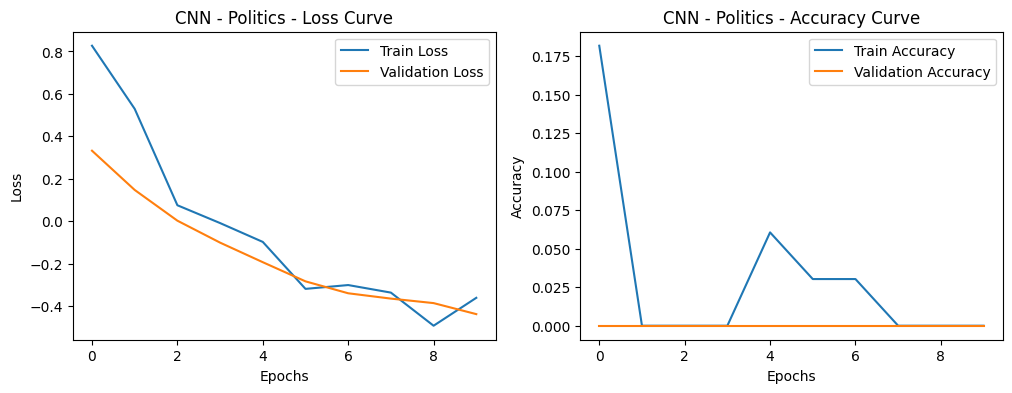

In [ ]:
# Run Tuner for CNN for each dataset
for (X_train_pad, X_test_pad, y_train, y_test), name in zip(train_test_data, dataset_names):
    print(f"\n--- Running CNN Tuner for {name} ---")
    cnn_tuner = kt.Hyperband(
        build_cnn_model,
        objective='val_accuracy',
        max_epochs=10,
        factor=3,
        directory='cnn_tuner',
        project_name=name
    )
    run_tuner_model(cnn_tuner, X_train_pad, X_test_pad, y_train, y_test, f"CNN - {name}")

Trial 30 Complete [00h 00m 13s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.4444444477558136
Total elapsed time: 00h 06m 05s

Best hyperparameters for Bi-LSTM - Politics:
{'lstm_units': 160, 'dropout_rate': 0.6000000000000001, 'dense_units': 40, 'learning_rate': 0.0002410137413750422, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.3845 - loss: 0.9095 - val_accuracy: 0.2222 - val_loss: 0.7720
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3693 - loss: 0.7850 - val_accuracy: 0.4444 - val_loss: 0.6361
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3928 - loss: 0.6890 - val_accuracy: 0.0000e+00 - val_loss: 0.6850
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1387 - loss: 0.6725 - val_accuracy: 0.0000e+00 - val_loss: 0.6230
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1231 - loss: 0.6708 - val_accuracy: 0.0000e+00 - val_los

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


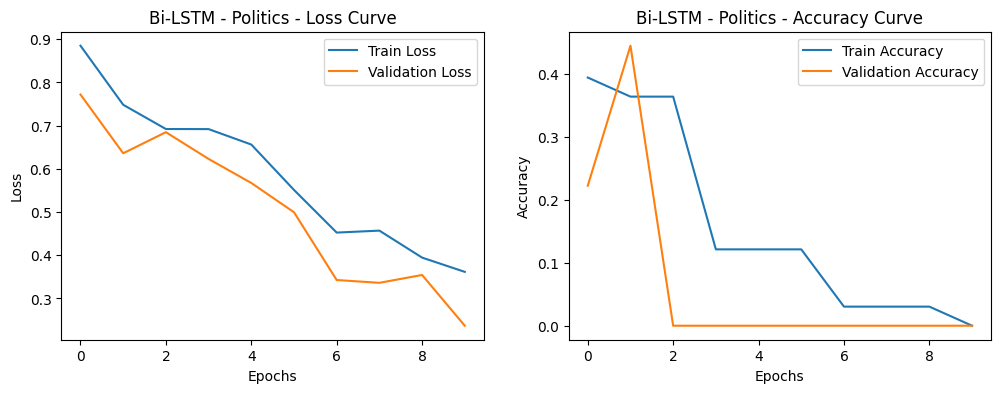

In [ ]:
# Run Tuner for Bi-LSTM for each dataset
for (X_train_pad, X_test_pad, y_train, y_test), name in zip(train_test_data, dataset_names):
    print(f"\n--- Running Bi-LSTM Tuner for {name} ---")
    bilstm_tuner = kt.Hyperband(
        build_bilstm_model,
        objective='val_accuracy',
        max_epochs=10,
        factor=3,
        directory='bilstm_tuner',
        project_name=name
    )
    run_tuner_model(bilstm_tuner, X_train_pad, X_test_pad, y_train, y_test, f"Bi-LSTM - {name}")


--- Running CNN Tuner for Combined Dataset ---

Best hyperparameters for CNN - Combined Dataset:
{'filters': 32, 'kernel_size': 7, 'dense_units': 90, 'dropout_rate': 0.5, 'learning_rate': 0.0005875357950035947, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8033/8033 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.4303 - loss: -39.6748 - val_accuracy: 0.4485 - val_loss: -682.4094
Epoch 2/10
8033/8033 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.4708 - loss: -1840.9890 - val_accuracy: 0.4583 - val_loss: -5282.4282
Epoch 3/10
8033/8033 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.4749 - loss: -9734.4932 - val_accuracy: 0.4648 - val_loss: -16978.4238
Epoch 4/10
8033/8033 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.4800 - loss: -26798.0840 - val_accuracy: 0.4527 - val_loss: -38162.8008
Epoch 5/10
8033/8033 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.4744 - loss: -59984.1328 - val_accuracy: 0.4617 - val_loss: -72811.2500
Epoch 6/10
8033/8033 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.4808 - loss: -107724.1406 - val_accuracy: 0.4644 - val_loss: -124795.9297
Epoch 7/10
8033/8033 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.4812 - loss: -180045.9062 - val_accuracy: 0.4550 - val_loss: -189072.4688
Epoch 8/10
8033/8033 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CNN - Combined Dataset - Accuracy: 0.4754163658542657, F1: 0.42181931588617816, Precision: 0.4337415866153037, Recall: 0.4754163658542657


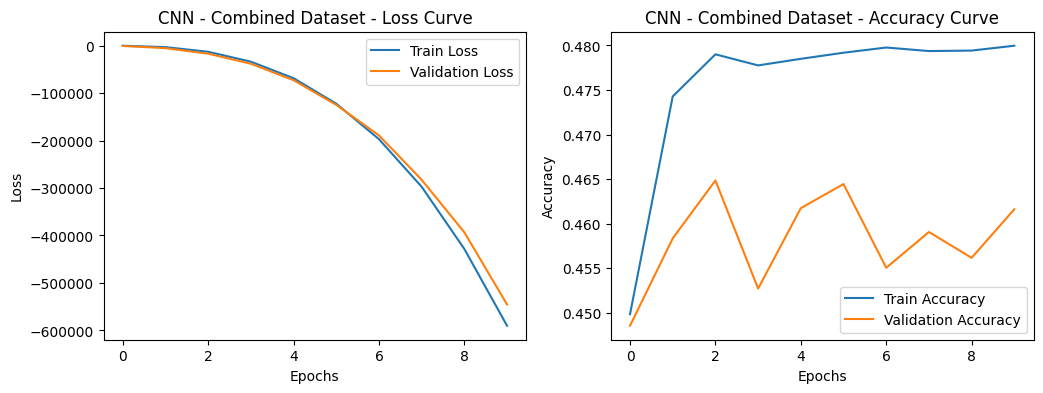

In [ ]:
# Combine all datasets and evaluate with CNN and Bi-LSTM models using tuned hyperparameters
combined_X_train_pad = np.vstack([X_train_pad for X_train_pad, _, _, _ in train_test_data])
combined_X_test_pad = np.vstack([X_test_pad for _, X_test_pad, _, _ in train_test_data])
combined_y_train = np.concatenate([y_train for _, _, y_train, _ in train_test_data])
combined_y_test = np.concatenate([y_test for _, _, _, y_test in train_test_data])

# CNN Combined
print("\n--- Running CNN Tuner for Combined Dataset ---")
run_tuner_model(cnn_tuner, combined_X_train_pad, combined_X_test_pad, combined_y_train, combined_y_test, 'CNN - Combined Dataset')


--- Running Bi-LSTM Tuner for Combined Dataset ---

Best hyperparameters for Bi-LSTM - Combined Dataset:
{'lstm_units': 160, 'dropout_rate': 0.6000000000000001, 'dense_units': 40, 'learning_rate': 0.0002410137413750422, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8033/8033 ━━━━━━━━━━━━━━━━━━━━ 94s 11ms/step - accuracy: 0.3664 - loss: 0.3869 - val_accuracy: 0.4500 - val_loss: -0.8907
Epoch 2/10
8033/8033 ━━━━━━━━━━━━━━━━━━━━ 91s 11ms/step - accuracy: 0.3918 - loss: -0.8997 - val_accuracy: 0.4743 - val_loss: -10.7916
Epoch 3/10
8033/8033 ━━━━━━━━━━━━━━━━━━━━ 91s 11ms/step - accuracy: 0.3902 - loss: -13.2880 - val_accuracy: 0.3676 - val_loss: -23.6330
Epoch 4/10
8033/8033 ━━━━━━━━━━━━━━━━━━━━ 91s 11ms/step - accuracy: 0.4024 - loss: -54.9016 - val_accuracy: 0.4542 - val_loss: -120.9717
Epoch 5/10
8033/8033 ━━━━━━━━━━━━━━━━━━━━ 91s 11ms/step - accuracy: 0.4177 - loss: -153.0071 - val_accuracy: 0.4558 - val_loss: -235.1888
Epoch 6/10
8033/8033 ━━━━━━━━━━━━━━━━━━━━ 91s 11ms/step - accuracy: 0.4242 - loss: -307.2396 - val_accuracy: 0.4636 - val_loss: -456.5395
Epoch 7/10
8033/8033 ━━━━━━━━━━━━━━━━━━━━ 91s 11ms/step - accuracy: 0.4307 - loss: -563.9847 - val_accuracy: 0.4564 - val_loss: -659.9006
Epoch 8/10
8033/8033 ━━━━━━━━━━━━━━━━━━━━ 91s 11ms/step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Bi-LSTM - Combined Dataset - Accuracy: 0.4421568871517837, F1: 0.3603658822150157, Precision: 0.4903248482951645, Recall: 0.4421568871517837


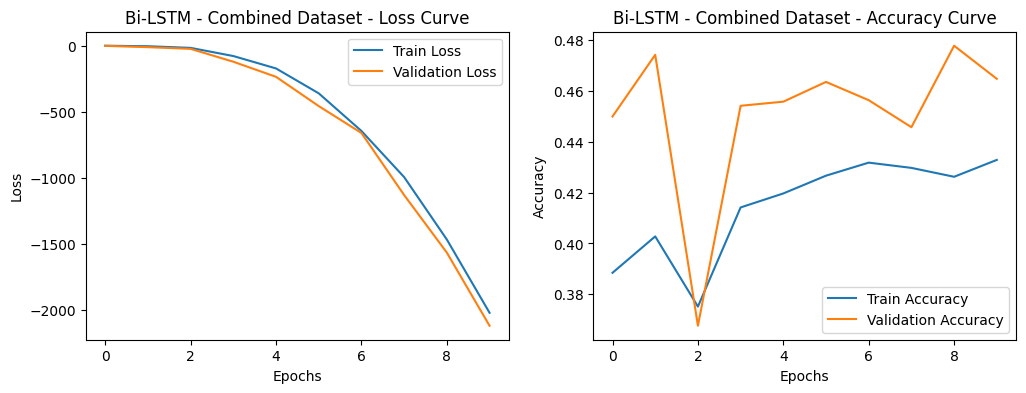

In [ ]:
# Bi-LSTM Combined
print("\n--- Running Bi-LSTM Tuner for Combined Dataset ---")
run_tuner_model(bilstm_tuner, combined_X_train_pad, combined_X_test_pad, combined_y_train, combined_y_test, 'Bi-LSTM - Combined Dataset')

**Untuned Results. Do Not Change**


Training on dataset: Twitter
Epoch 1/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.4009 - loss: -11.1123 - val_accuracy: 0.4798 - val_loss: -260.1721
Epoch 2/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4713 - loss: -551.8152 - val_accuracy: 0.4959 - val_loss: -1986.7794
Epoch 3/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4767 - loss: -2799.7275 - val_accuracy: 0.4964 - val_loss: -6010.2119
Epoch 4/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4786 - loss: -7935.8062 - val_accuracy: 0.5004 - val_loss: -13121.2754
Epoch 5/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4793 - loss: -15758.4258 - val_accuracy: 0.4912 - val_loss: -24157.1406
Epoch 6/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4775 - loss: -28423.1875 - val_accuracy: 0.4948 - val_loss: -39743.0742
Epoch 7/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4749 - loss: -47143.1445 - val_accuracy: 0.5027 - val_loss: -60096.7070
E

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dataset: Twitter
CNN - Accuracy: 0.5046479521398988, F1: 0.4467460600382834, Precision: 0.4870884789950968, Recall: 0.5046479521398988


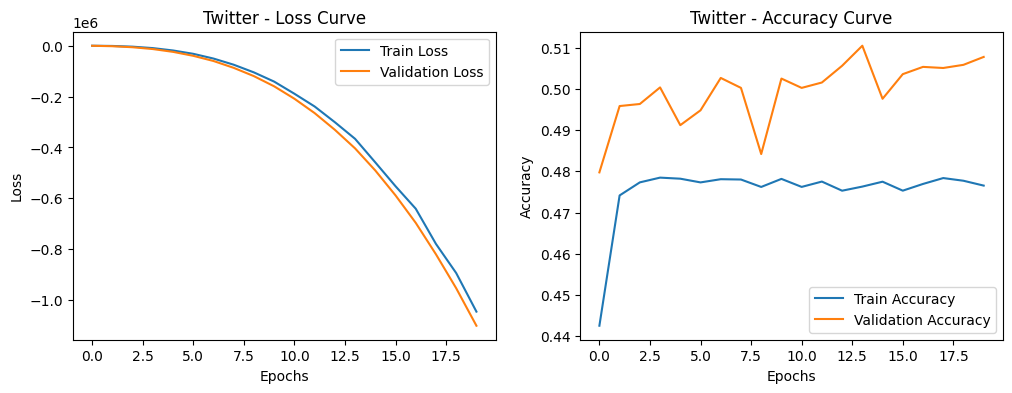


Training on dataset: Reddit
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


745/745 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3540 - loss: 0.0832 - val_accuracy: 0.3482 - val_loss: -9.9051
Epoch 2/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3594 - loss: -31.2096 - val_accuracy: 0.3482 - val_loss: -150.9508
Epoch 3/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4042 - loss: -255.9826 - val_accuracy: 0.4720 - val_loss: -563.3107
Epoch 4/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4825 - loss: -728.4008 - val_accuracy: 0.4643 - val_loss: -1296.8121
Epoch 5/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4810 - loss: -1518.4055 - val_accuracy: 0.4653 - val_loss: -2426.4961
Epoch 6/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4798 - loss: -3041.5889 - val_accuracy: 0.4688 - val_loss: -3936.7561
Epoch 7/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4805 - loss: -4870.2954 - val_accuracy: 0.4770 - val_loss: -5853.2759
Epoch 8/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4900 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


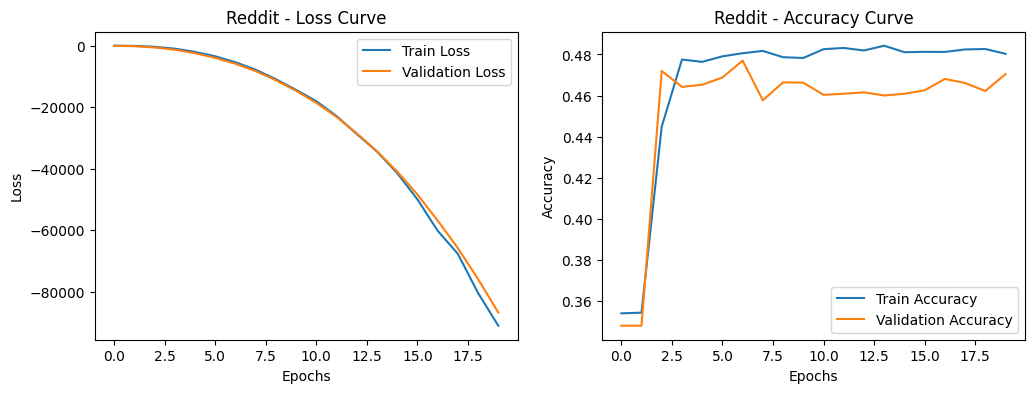


Training on dataset: News
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.1131 - loss: 0.6123 - val_accuracy: 0.0000e+00 - val_loss: 0.2463
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0688 - loss: 0.6547 - val_accuracy: 0.0000e+00 - val_loss: -0.0060
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0438 - loss: -0.0403 - val_accuracy: 0.0000e+00 - val_loss: -0.1182
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0383 - loss: -0.2134 - val_accuracy: 0.0156 - val_loss: -0.1911
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0696 - loss: -0.7576 - val_accuracy: 0.0000e+00 - val_loss: -0.3478
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0668 - loss: -0.8599 - val_accuracy: 0.0000e+00 - val_loss: -0.4700
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0877 - loss: -0.2252 - val_accuracy: 0.0312 - val_loss: -0.5821
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1290 - loss: -0.9247 - val_accuracy: 0.0312 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


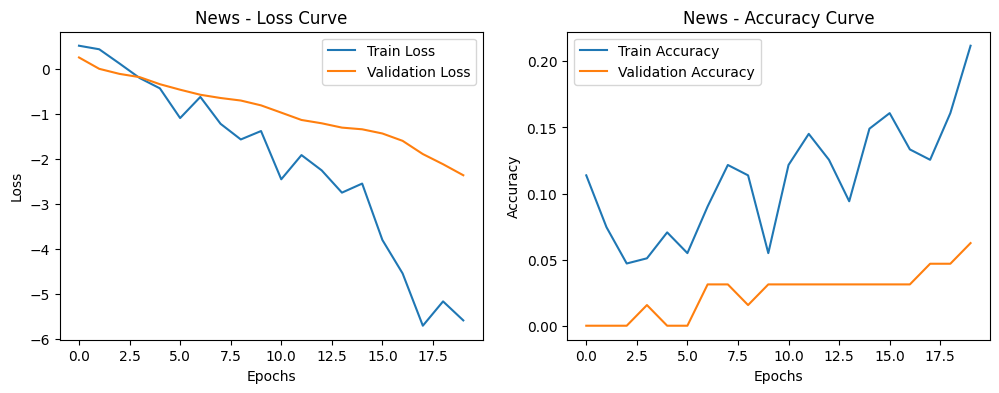


Training on dataset: Sports
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.2062 - loss: 0.7105 - val_accuracy: 0.0000e+00 - val_loss: 0.6594
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0295 - loss: 0.6475 - val_accuracy: 0.0000e+00 - val_loss: 0.6433
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0000e+00 - loss: 0.5432 - val_accuracy: 0.0000e+00 - val_loss: 0.6204
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0589 - loss: 0.4504 - val_accuracy: 0.0000e+00 - val_loss: 0.5980
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: 0.5078 - val_accuracy: 0.0000e+00 - val_loss: 0.5627
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0000e+00 - loss: 0.4463 - val_accuracy: 0.0000e+00 - val_loss: 0.5178
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0589 - loss: 0.2578 - val_accuracy: 0.0000e+00 - val_loss: 0.4736
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0884 - loss: 0.1055 - val_accuracy:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dataset: Sports
CNN - Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0


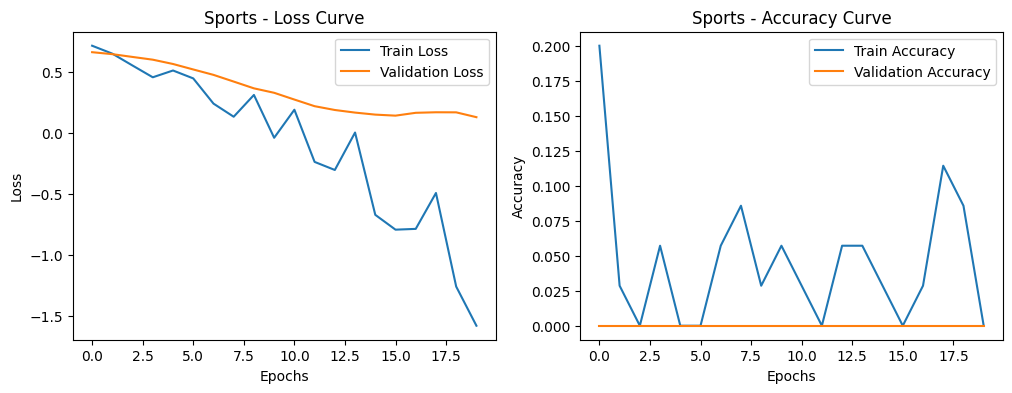


Training on dataset: Education
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1875 - loss: 0.7565 - val_accuracy: 0.0000e+00 - val_loss: 0.4535
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0000e+00 - loss: 0.4818 - val_accuracy: 0.0000e+00 - val_loss: 0.3615
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0312 - loss: 0.0431 - val_accuracy: 0.0000e+00 - val_loss: 0.2468
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0625 - loss: 0.1852 - val_accuracy: 0.0000e+00 - val_loss: 0.1114
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0000e+00 - loss: -0.2787 - val_accuracy: 0.0000e+00 - val_loss: -0.0057
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0000e+00 - loss: -0.3257 - val_accuracy: 0.0000e+00 - val_loss: -0.0961
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0312 - loss: -0.3612 - val_accuracy: 0.0000e+00 - val_loss: -0.1908
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0312 - loss: -0.5729 - val_ac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dataset: Education
CNN - Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0


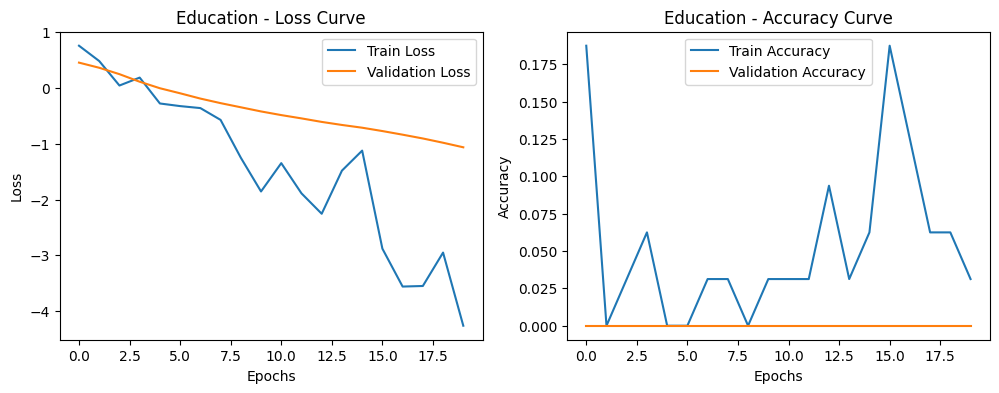


Training on dataset: Finance
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3333 - loss: 0.2864 - val_accuracy: 0.3750 - val_loss: 0.5421
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3333 - loss: 0.4889 - val_accuracy: 0.3750 - val_loss: 0.6871
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4000 - loss: 0.3366 - val_accuracy: 0.5000 - val_loss: 0.8790
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3333 - loss: 0.2974 - val_accuracy: 0.5000 - val_loss: 1.0788
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7000 - loss: -0.0688 - val_accuracy: 0.5000 - val_loss: 1.0417
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6000 - loss: -0.1512 - val_accuracy: 0.5000 - val_loss: 0.9476
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6000 - loss: -0.0892 - val_accuracy: 0.5000 - val_loss: 0.8281
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5667 - loss: -0.2081 - val_accuracy: 0.2500 - val_loss: 0.6844
Epoch 9/2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


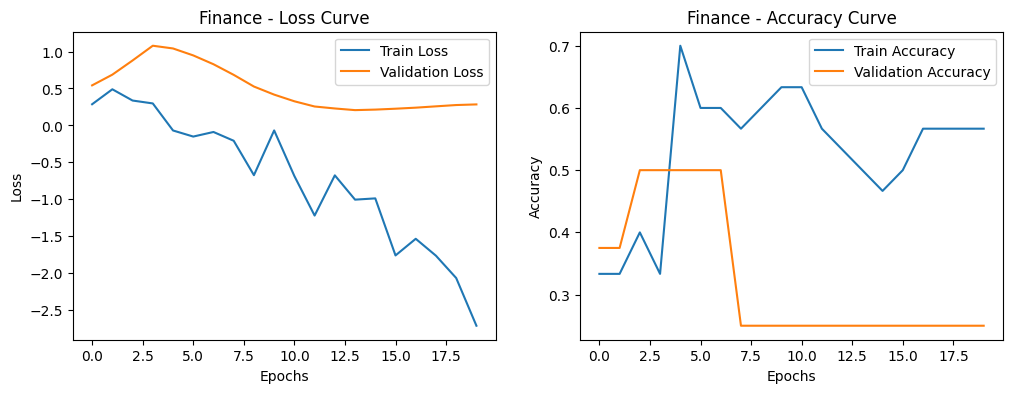


Training on dataset: Politics
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3674 - loss: 1.1920 - val_accuracy: 0.0000e+00 - val_loss: 0.5052
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1531 - loss: 0.2020 - val_accuracy: 0.0000e+00 - val_loss: 0.2756
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0612 - loss: -0.0854 - val_accuracy: 0.0000e+00 - val_loss: 0.3210
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1225 - loss: -0.1505 - val_accuracy: 0.0000e+00 - val_loss: 0.3144
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2039 - loss: -0.2357 - val_accuracy: 0.0000e+00 - val_loss: 0.2030
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1837 - loss: -0.2102 - val_accuracy: 0.0000e+00 - val_loss: 0.1184
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1531 - loss: -0.6074 - val_accuracy: 0.0000e+00 - val_loss: -0.0309
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1531 - loss: -0.8266 - val_accuracy: 0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


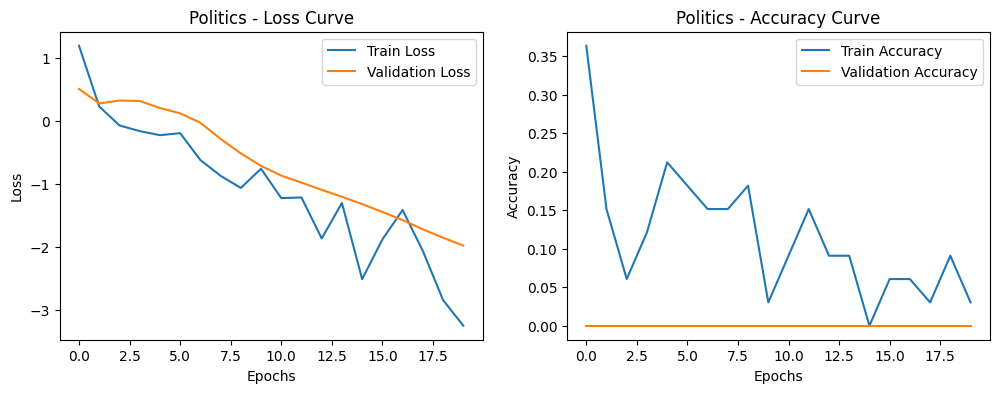

In [ ]:
# Loop through each dataset individually
for (X_train_pad, X_test_pad, y_train, y_test), name in zip(train_test_data, dataset_names):
    train_evaluate_cnn(X_train_pad, X_test_pad, y_train, y_test, name, embedding_matrix)


Training on dataset: Combined Dataset
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4017/4017 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.3987 - loss: -56.5942 - val_accuracy: 0.4535 - val_loss: -899.7192
Epoch 2/20
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3989 - loss: -2194.0413 - val_accuracy: 0.4641 - val_loss: -6115.5015
Epoch 3/20
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3850 - loss: -10203.7139 - val_accuracy: 0.4275 - val_loss: -17771.7246
Epoch 4/20
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3872 - loss: -26330.9863 - val_accuracy: 0.3753 - val_loss: -37504.6914
Epoch 5/20
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3680 - loss: -54895.1875 - val_accuracy: 0.4338 - val_loss: -67814.2812
Epoch 6/20
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4631 - loss: -96824.3672 - val_accuracy: 0.4319 - val_loss: -110463.9375
Epoch 7/20
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4647 - loss: -152862.1719 - val_accuracy: 0.4395 - val_loss: -169833.4688
Epoch 8/20
4017/4017 ━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dataset: Combined Dataset
CNN - Accuracy: 0.45475366576215487, F1: 0.40722577725027714, Precision: 0.38758878069015246, Recall: 0.45475366576215487


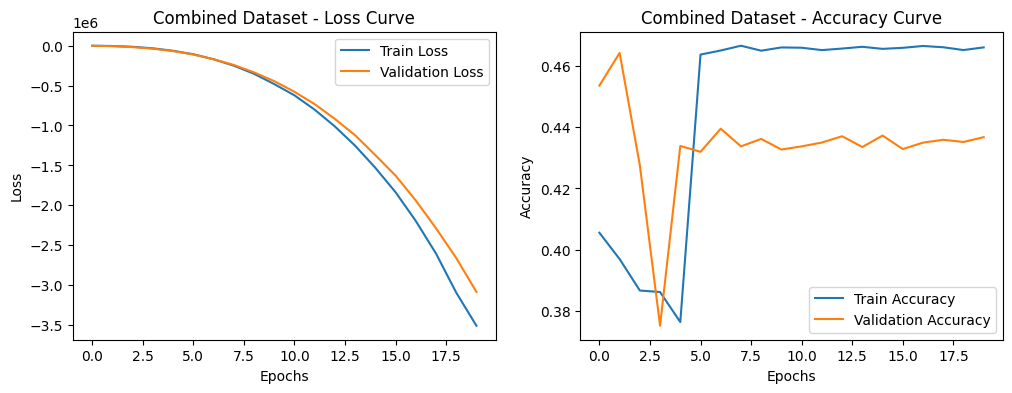

In [ ]:
# Combine all datasets and evaluate
combined_X_train_pad = np.vstack([X_train_pad for X_train_pad, _, _, _ in train_test_data])
combined_X_test_pad = np.vstack([X_test_pad for _, X_test_pad, _, _ in train_test_data])
combined_y_train = np.concatenate([y_train for _, _, y_train, _ in train_test_data])
combined_y_test = np.concatenate([y_test for _, _, _, y_test in train_test_data])

train_evaluate_cnn(combined_X_train_pad, combined_X_test_pad, combined_y_train, combined_y_test, 'Combined Dataset', embedding_matrix)

In [ ]:
# Bi-LSTM Hyperparameters (These will be tuned)
lstm_epochs = 20
lstm_batch_size = 32

# Modify the Bi-LSTM model to include hyperparameters for tuning
def build_bilstm_model(hp):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=True,
        dropout=hp.Float('lstm_dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    )))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to Train and Evaluate Bi-LSTM on a Dataset
def train_evaluate_bilstm(X_train_pad, X_test_pad, y_train, y_test, name, embedding_matrix=None):
    print(f"\nTraining on dataset: {name}")
    bilstm_model = create_bilstm_model(len(word_index) + 1, embedding_dim, lstm_units, lstm_dropout_rate, lstm_dense_units, lstm_learning_rate, embedding_matrix)

    history = bilstm_model.fit(X_train_pad, y_train, epochs=lstm_epochs, batch_size=lstm_batch_size, validation_split=0.2)

    # Evaluate on test data
    bilstm_metrics = bilstm_model.evaluate(X_test_pad, y_test)
    print(f"Dataset: {name} - Bi-LSTM - Test Loss: {bilstm_metrics[0]}, Test Accuracy: {bilstm_metrics[1]}")

    # Predict and evaluate with classification metrics
    predictions = bilstm_model.predict(X_test_pad)
    predictions = [1 if p >= 0.5 else 0 for p in predictions]
    bilstm_metrics = evaluate_model(pd.DataFrame({'label': y_test, 'bilstm_prediction': predictions}), 'bilstm_prediction')
    print(f"Dataset: {name}")
    print(f"Bi-LSTM - Accuracy: {bilstm_metrics[0]}, F1: {bilstm_metrics[1]}, Precision: {bilstm_metrics[2]}, Recall: {bilstm_metrics[3]}")

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Training on dataset: Twitter
Epoch 1/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.3652 - loss: -1.3875 - val_accuracy: 0.3903 - val_loss: -27.5830
Epoch 2/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.4071 - loss: -59.3163 - val_accuracy: 0.4463 - val_loss: -189.9255
Epoch 3/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.4146 - loss: -275.8530 - val_accuracy: 0.3979 - val_loss: -579.4885
Epoch 4/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.3978 - loss: -599.3408 - val_accuracy: 0.4240 - val_loss: -971.4766
Epoch 5/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.3975 - loss: -975.4066 - val_accuracy: 0.3758 - val_loss: -1554.8136
Epoch 6/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.3776 - loss: -1763.5699 - val_accuracy: 0.4078 - val_loss: -2516.0142
Epoch 7/20
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.3708 - loss: -2717.3567 - val_accuracy: 0.4032 - val_loss: -3630.3123
Epo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dataset: Twitter
Bi-LSTM - Accuracy: 0.35263077159073475, F1: 0.20331483083173643, Precision: 0.5293740094039572, Recall: 0.35263077159073475


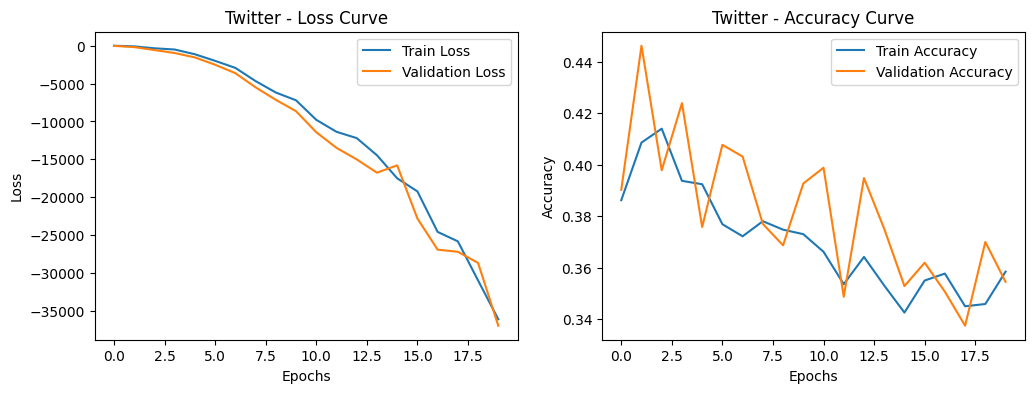


Training on dataset: Reddit
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


745/745 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3641 - loss: 0.4409 - val_accuracy: 0.3482 - val_loss: -0.5053
Epoch 2/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3579 - loss: -0.3392 - val_accuracy: 0.3482 - val_loss: -3.5368
Epoch 3/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3668 - loss: -5.4415 - val_accuracy: 0.3483 - val_loss: -6.7247
Epoch 4/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3555 - loss: -11.2096 - val_accuracy: 0.3958 - val_loss: -33.8897
Epoch 5/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3953 - loss: -34.7234 - val_accuracy: 0.4300 - val_loss: -60.6433
Epoch 6/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3932 - loss: -70.3079 - val_accuracy: 0.4045 - val_loss: -107.3053
Epoch 7/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3875 - loss: -123.0769 - val_accuracy: 0.3711 - val_loss: -144.8684
Epoch 8/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3807 - loss: -17

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


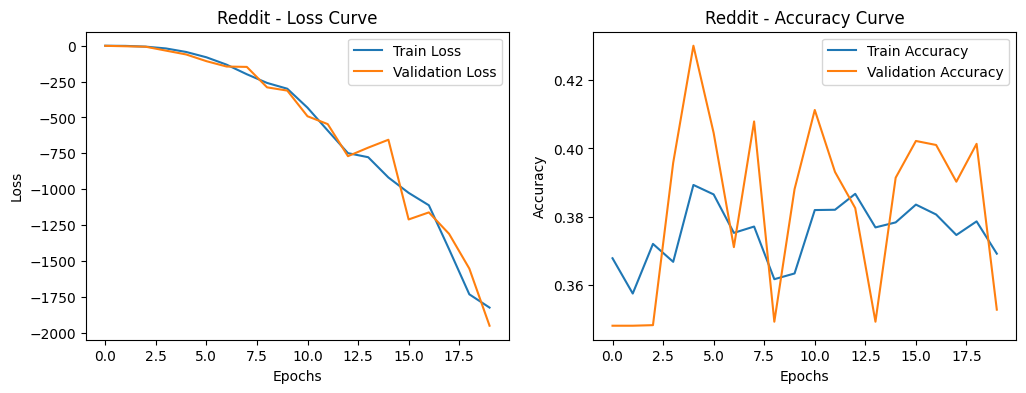


Training on dataset: News
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.0686 - loss: 0.5396 - val_accuracy: 0.0000e+00 - val_loss: 0.2899
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0064 - loss: 0.4143 - val_accuracy: 0.0000e+00 - val_loss: 0.1751
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.3697 - val_accuracy: 0.0000e+00 - val_loss: 0.1301
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 0.4847 - val_accuracy: 0.0000e+00 - val_loss: 0.1470
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 0.4641 - val_accuracy: 0.0000e+00 - val_loss: 0.1508
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 0.3995 - val_accuracy: 0.0000e+00 - val_loss: 0.2229
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.3711 - val_accuracy: 0.0000e+00 - val_loss: 0.0722
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 0.1111 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


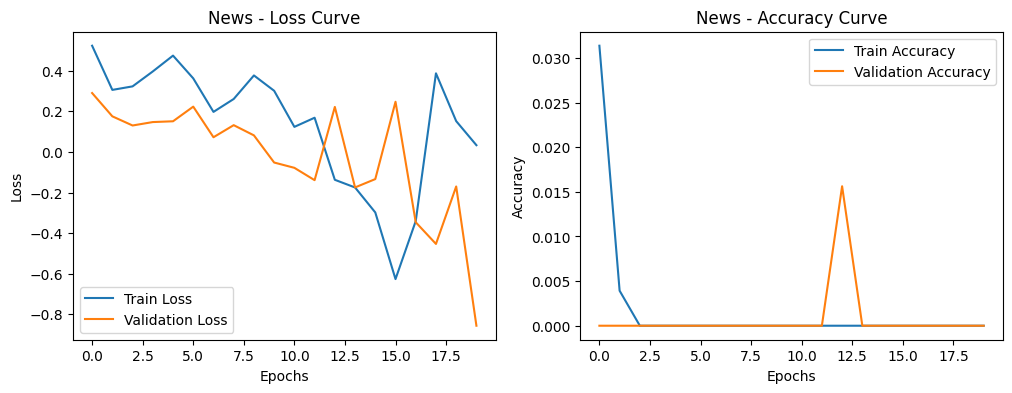


Training on dataset: Sports
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - accuracy: 0.2842 - loss: 0.5816 - val_accuracy: 0.1111 - val_loss: 0.5837
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1179 - loss: 0.7089 - val_accuracy: 0.0000e+00 - val_loss: 0.6492
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0000e+00 - loss: 0.6310 - val_accuracy: 0.0000e+00 - val_loss: 0.5216
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0000e+00 - loss: 0.3077 - val_accuracy: 0.0000e+00 - val_loss: 0.4450
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0295 - loss: 0.1549 - val_accuracy: 0.0000e+00 - val_loss: 0.3309
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0000e+00 - loss: 0.1113 - val_accuracy: 0.0000e+00 - val_loss: 0.4560
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0295 - loss: 0.2737 - val_accuracy: 0.0000e+00 - val_loss: 0.4696
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0884 - loss: 0.0297 - val_accuracy: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dataset: Sports
Bi-LSTM - Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0


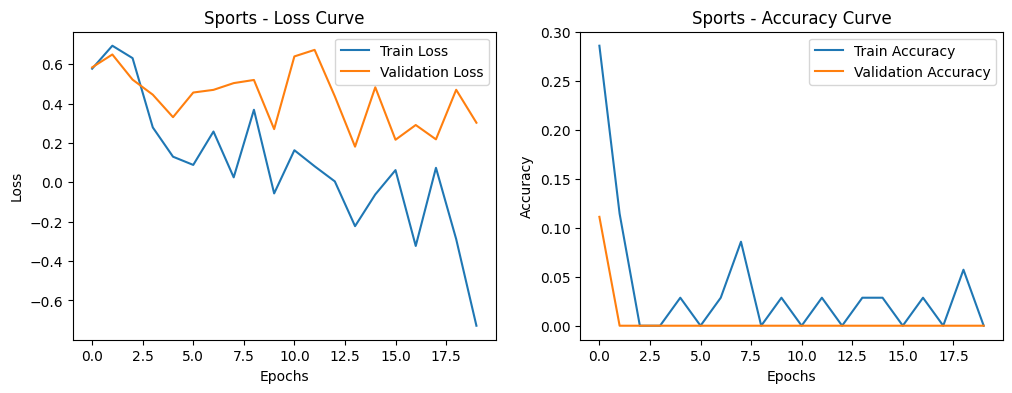


Training on dataset: Education


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: 0.8428 - val_accuracy: 0.3333 - val_loss: 0.7350
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1562 - loss: 0.7014 - val_accuracy: 0.0000e+00 - val_loss: 0.6989
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1562 - loss: 0.6654 - val_accuracy: 0.0000e+00 - val_loss: 0.6429
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.0312 - loss: 0.6731 - val_accuracy: 0.0000e+00 - val_loss: 0.6462
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0625 - loss: 0.6724 - val_accuracy: 0.0000e+00 - val_loss: 0.6281
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.0000e+00 - loss: 0.6249 - val_accuracy: 0.0000e+00 - val_loss: 0.6232
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0000e+00 - loss: 0.5962 - val_accuracy: 0.0000e+00 - val_loss: 0.6103
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0312 - loss: 0.6271 - val_accura

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dataset: Education
Bi-LSTM - Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0


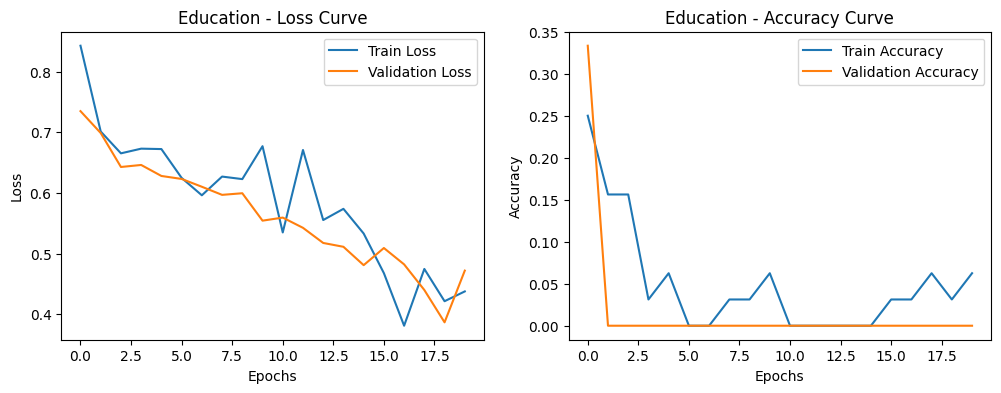


Training on dataset: Finance
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1667 - loss: 0.6856 - val_accuracy: 0.3750 - val_loss: 0.7695
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5000 - loss: 0.7046 - val_accuracy: 0.2500 - val_loss: 0.6453
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4667 - loss: 0.6845 - val_accuracy: 0.2500 - val_loss: 0.7517
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5667 - loss: 0.7036 - val_accuracy: 0.5000 - val_loss: 0.6648
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4667 - loss: 0.7184 - val_accuracy: 0.2500 - val_loss: 0.7398
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5000 - loss: 0.6581 - val_accuracy: 0.5000 - val_loss: 0.7591
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5667 - loss: 0.6459 - val_accuracy: 0.3750 - val_loss: 0.7666
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6667 - loss: 0.6863 - val_accuracy: 0.3750 - val_loss: 0.7472
Epoch 9/20
1/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


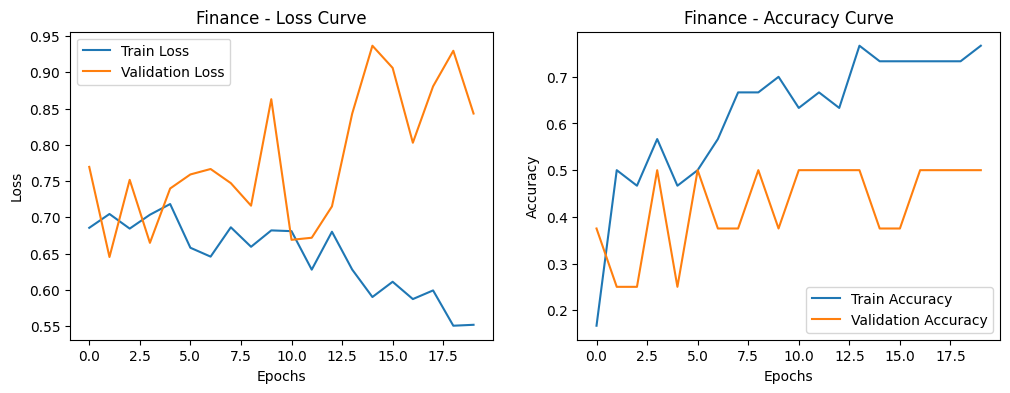


Training on dataset: Politics
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.3264 - loss: 0.8231 - val_accuracy: 0.3333 - val_loss: 0.7838
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2652 - loss: 0.7716 - val_accuracy: 0.2222 - val_loss: 0.6488
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2756 - loss: 0.6911 - val_accuracy: 0.2222 - val_loss: 0.6618
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1733 - loss: 0.6712 - val_accuracy: 0.2222 - val_loss: 0.6711
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1837 - loss: 0.6054 - val_accuracy: 0.1111 - val_loss: 0.5391
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1837 - loss: 0.6105 - val_accuracy: 0.1111 - val_loss: 0.5902
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1225 - loss: 0.6555 - val_accuracy: 0.1111 - val_loss: 0.5478
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1733 - loss: 0.5746 - val_accuracy: 0.1111 - val_loss: 0.5068
Epoch 9/20

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


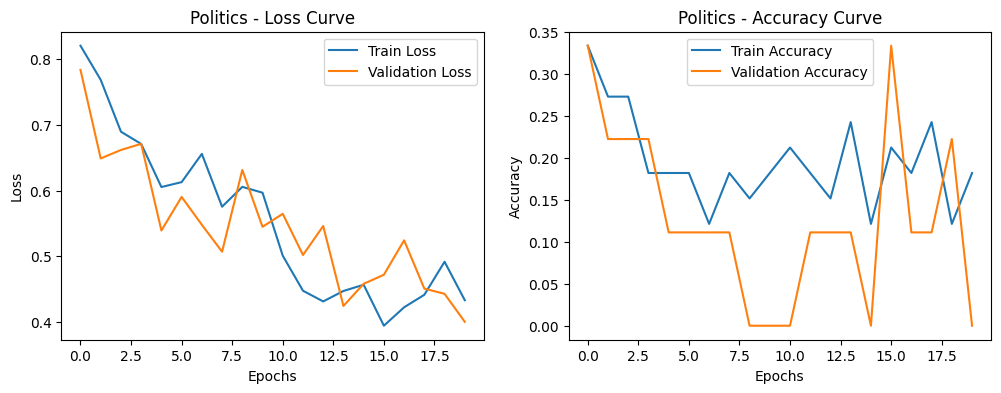

In [ ]:
# Loop through each dataset individually
for (X_train_pad, X_test_pad, y_train, y_test), name in zip(train_test_data, dataset_names):
    train_evaluate_bilstm(X_train_pad, X_test_pad, y_train, y_test, name, embedding_matrix)


Training on dataset: Combined Dataset
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4017/4017 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - accuracy: 0.3581 - loss: -1.3555 - val_accuracy: 0.4414 - val_loss: -29.2371
Epoch 2/20
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 48s 12ms/step - accuracy: 0.4087 - loss: -72.2138 - val_accuracy: 0.3969 - val_loss: -182.1522
Epoch 3/20
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.4051 - loss: -273.0879 - val_accuracy: 0.4307 - val_loss: -491.4717
Epoch 4/20
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.4083 - loss: -611.5907 - val_accuracy: 0.4356 - val_loss: -809.9156
Epoch 5/20
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.4039 - loss: -1387.3885 - val_accuracy: 0.4364 - val_loss: -1534.6969
Epoch 6/20
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.4033 - loss: -2076.9700 - val_accuracy: 0.4462 - val_loss: -2268.1558
Epoch 7/20
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 48s 12ms/step - accuracy: 0.4004 - loss: -3041.0830 - val_accuracy: 0.4088 - val_loss: -2963.2144
Epoch 8/20
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dataset: Combined Dataset
Bi-LSTM - Accuracy: 0.37558814010804353, F1: 0.24737471229740665, Precision: 0.5104211710583563, Recall: 0.37558814010804353


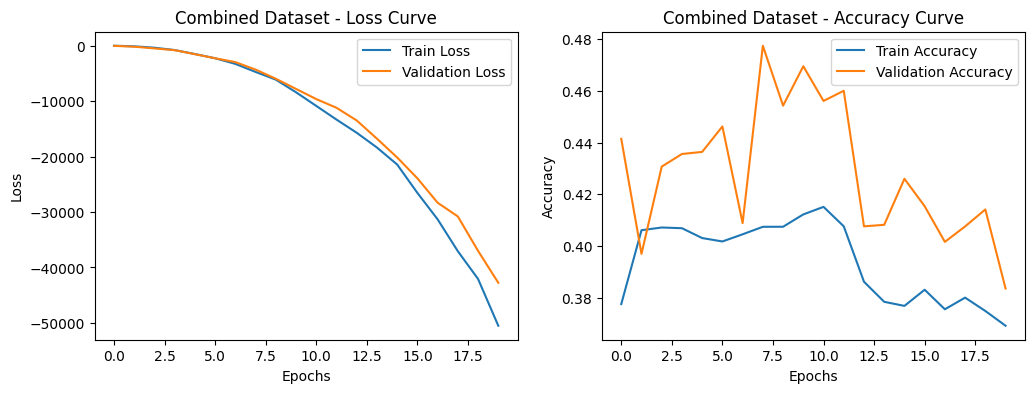

In [ ]:
# Combine all datasets and evaluate
combined_X_train_pad = np.vstack([X_train_pad for X_train_pad, _, _, _ in train_test_data])
combined_X_test_pad = np.vstack([X_test_pad for _, X_test_pad, _, _ in train_test_data])
combined_y_train = np.concatenate([y_train for _, _, y_train, _ in train_test_data])
combined_y_test = np.concatenate([y_test for _, _, _, y_test in train_test_data])

train_evaluate_bilstm(combined_X_train_pad, combined_X_test_pad, combined_y_train, combined_y_test, 'Combined Dataset', embedding_matrix)